# Image Normalization

[Normalization](https://en.wikipedia.org/wiki/Normalization_(image_processing)) is commonly used for __preprocessing__ biological images. During normalization, the range of pixel intensity values is changed.  Therefore, it is crucial for differing pixel intensities between images to ensure comparability and quantification of biological features across different images.

However, while normalization can enhance consistency and detectability of patterns, it can also lead to distortion, i.e. suppression or exaggeration of signals, if it is not carefully applied. Finding the balance between noise reduction and risk of losing biological variability is crucial for successfully analyzing images.

This notebook is meant to demonstrate __possible impacts and risks of normalization__ that need to be considered. In the end, there is an __overview of different normalization techniques__.

In [20]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from stackview import insight

For demonstrating how normalization works, we will use `blobs.tif` as an example image.

In [21]:
image = imread('../../data/blobs.tif')

Now we can use `stackview.insight` to display the image and essential properties of the image:

StackViewNDArray([[ 40,  32,  24, ..., 216, 200, 200],
                  [ 56,  40,  24, ..., 232, 216, 216],
                  [ 64,  48,  24, ..., 240, 232, 232],
                  ...,
                  [ 72,  80,  80, ...,  48,  48,  48],
                  [ 80,  80,  80, ...,  48,  48,  48],
                  [ 96,  88,  80, ...,  48,  48,  48]], dtype=uint8)
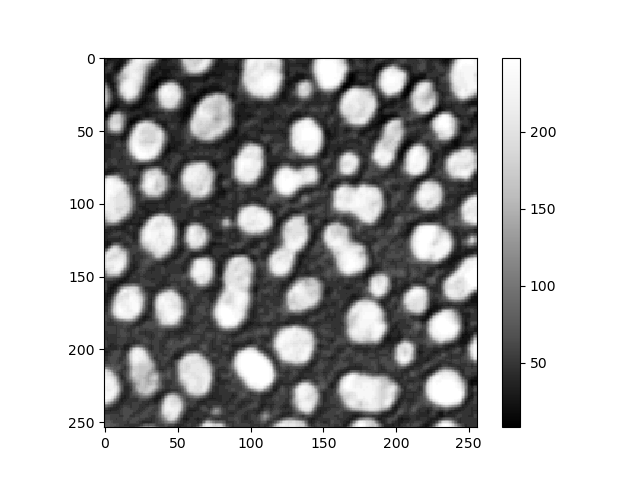
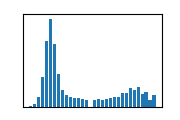

In [22]:

insight(image)

We can see that our image is of datatype unsigned 8-bit integer, short `uint8`. This means:
- __unsigned__: the values are always positive
- __8-bit__: we can have 2^8 = 256 different intensity levels ranging from 0 to 255. 
- __integer__: the values are whole numbers

We can also see how these intensity levels are distributed in the intensity histogram. Lets try out different ways to normalize this image:

## Min-Max Normalization

One of the most common ways to normalize data is [min-max normalization](https://en.wikipedia.org/wiki/Feature_scaling#Methods). Let us try it out:

StackViewNDArray([[0.13333333, 0.1       , 0.06666667, ..., 0.86666667,
                   0.8       , 0.8       ],
                  [0.2       , 0.13333333, 0.06666667, ..., 0.93333333,
                   0.86666667, 0.86666667],
                  [0.23333333, 0.16666667, 0.06666667, ..., 0.96666667,
                   0.93333333, 0.93333333],
                  ...,
                  [0.26666667, 0.3       , 0.3       , ..., 0.16666667,
                   0.16666667, 0.16666667],
                  [0.3       , 0.3       , 0.3       , ..., 0.16666667,
                   0.16666667, 0.16666667],
                  [0.36666667, 0.33333333, 0.3       , ..., 0.16666667,
                   0.16666667, 0.16666667]])
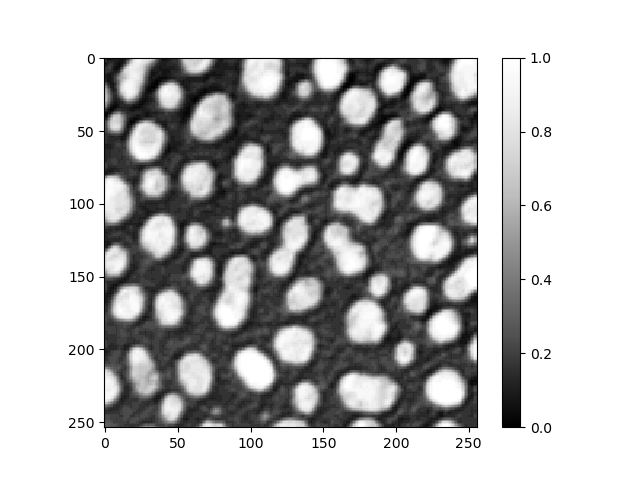
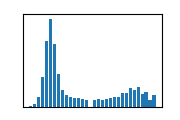

In [25]:
min_max = (image - image.min()) / (image.max() - image.min())
insight(min_max)

Min-max normalization leads to the transformation of the minimum intensity value of the image into a 0 and the maximum intensity value gets transformed into a 1. Every value in between then lies between 0 and 1. 

Therefore, we need to be able to represent decimal values and not whole numbers. Consequently, we cannot use a dtype of `uint8` anymore but need the floating point representation, here `float64`.

Let us compare the intensity histograms of our original and the min-max-normalized image:

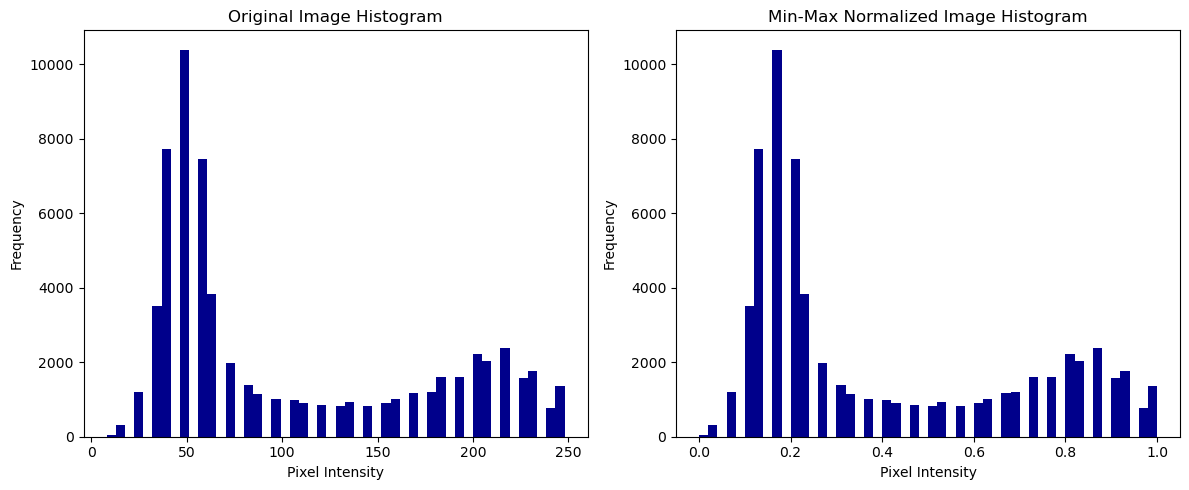

In [26]:
# Plot the histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  

# Original image histogram
axes[0].hist(image.ravel(), bins=50, color='darkblue')
axes[0].set_title('Original Image Histogram')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

# Min-max normalized image histogram
axes[1].hist(min_max.ravel(), bins=50, color='darkblue')
axes[1].set_title('Min-Max Normalized Image Histogram')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')

plt.tight_layout()  
plt.show()

We can see that the two histograms look very similar and the min-max normalization ensures that pixel values are scaled to a common range, here 0 to 1. This is particularly useful when working with different datasets that need to be compared or used, for example for a machine learning algorithm. 

But we need to keep in mind that min-max normalization can be highly sensitive to outliers. Let us try to introduce such an outlier to investigate its impact on the min-max normalization. We first set a square in the original image to an intensity value of 1000. Therfore, we also need to adjust the data type:

StackViewNDArray([[1000, 1000, 1000, ...,  216,  200,  200],
                  [1000, 1000, 1000, ...,  232,  216,  216],
                  [1000, 1000, 1000, ...,  240,  232,  232],
                  ...,
                  [  72,   80,   80, ...,   48,   48,   48],
                  [  80,   80,   80, ...,   48,   48,   48],
                  [  96,   88,   80, ...,   48,   48,   48]], dtype=uint16)
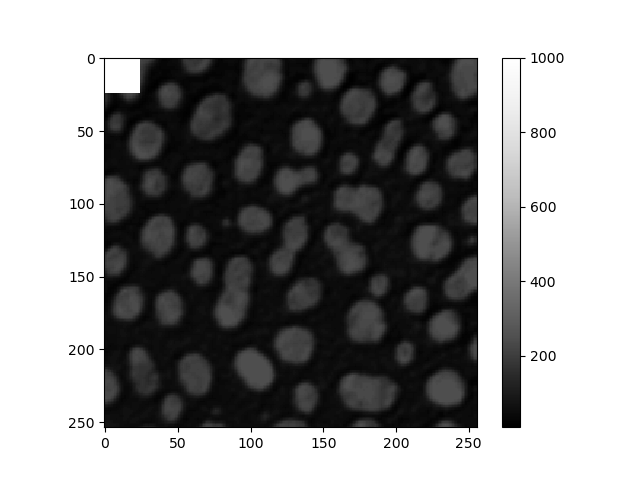
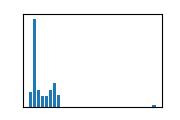

In [27]:
outlier_image = image.copy()
outlier_image = image.astype(np.uint16)
outlier_image[0:25, 0:25] = 1000  
insight(outlier_image)

We can see that our initial distribution is now skewed because the outlier is so far off the other values. Let us investigate how it impacts the min-max normalization.

In [30]:
min_max_outlier = (outlier_image - outlier_image.min()) / (outlier_image.max() - outlier_image.min())

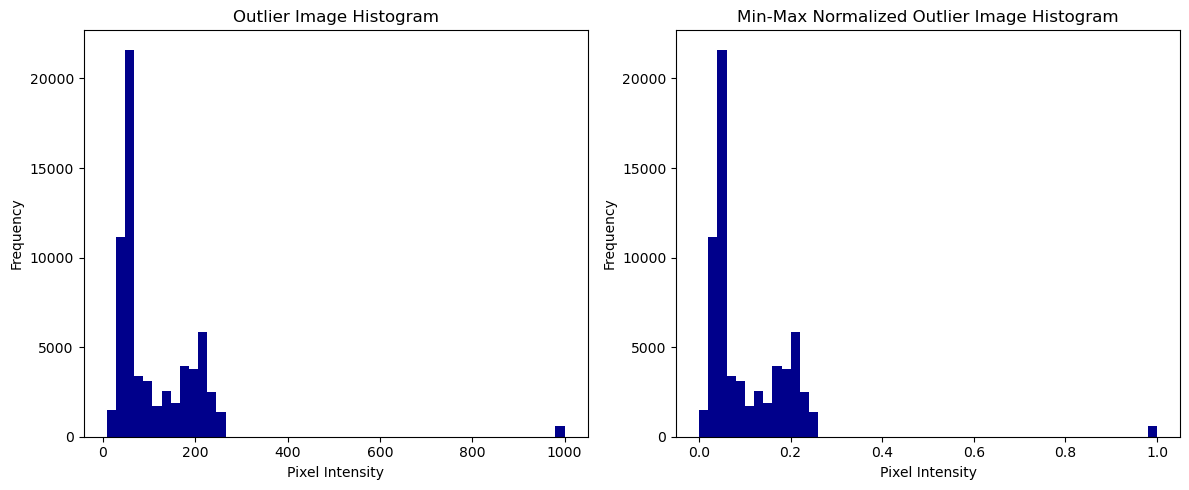

In [32]:
# Plot the histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create two subplots side by side

# Outlier image histogram
axes[0].hist(outlier_image.ravel(), bins=50, color='darkblue')
axes[0].set_title('Outlier Image Histogram')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

# Min-max normalized outlier image histogram
axes[1].hist(min_max_outlier.ravel(), bins=50, color='darkblue')
axes[1].set_title('Min-Max Normalized Outlier Image Histogram')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

If an image contains very dark or, like in our case, bright pixels (e.g. due to noise or artifacts), these extreme values stretch the normalization range, causing most of the pixel values to be squeezed into a narrow range. This compression results in a lower contrast in the rest of the image. A way to circumvent this behavior is to use Percentile-based Normalization.

## Percentile-based Normalization

Percentile-based Normalization takes into account the relative rank of each intensity in the distribution, making it more robust against outliers. This approach leads to less skewing of the distribution as the focus is on where the intensity value lies in the overall distribution.

StackViewNDArray([[4.35714286, 4.35714286, 4.35714286, ..., 0.85714286,
                   0.78571429, 0.78571429],
                  [4.35714286, 4.35714286, 4.35714286, ..., 0.92857143,
                   0.85714286, 0.85714286],
                  [4.35714286, 4.35714286, 4.35714286, ..., 0.96428571,
                   0.92857143, 0.92857143],
                  ...,
                  [0.21428571, 0.25      , 0.25      , ..., 0.10714286,
                   0.10714286, 0.10714286],
                  [0.25      , 0.25      , 0.25      , ..., 0.10714286,
                   0.10714286, 0.10714286],
                  [0.32142857, 0.28571429, 0.25      , ..., 0.10714286,
                   0.10714286, 0.10714286]])
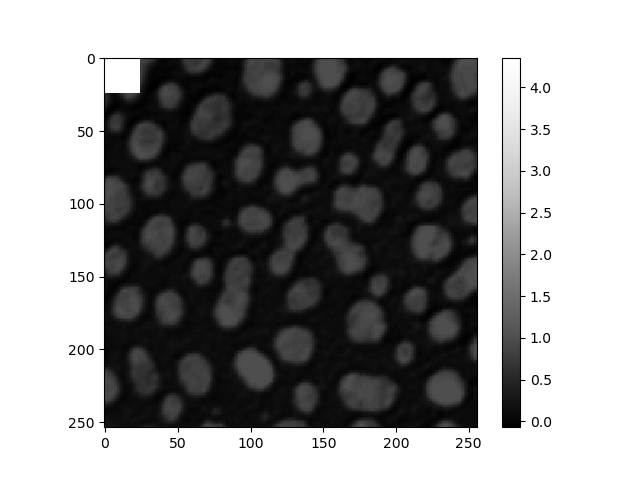
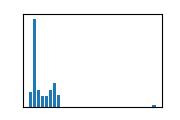

In [33]:
# Step 2: Compute percentiles
p1 = np.percentile(outlier_image, 1)
p99 = np.percentile(outlier_image, 99)

# Step 3: Perform percentile normalization
percentile_image_unclipped = (outlier_image - p1) / (p99 - p1)
insight(percentile_image_unclipped)

Now we still need to clip the distribution to 0 and 1 to get rid of the outlier:

StackViewNDArray([[1.        , 1.        , 1.        , ..., 0.85714286,
                   0.78571429, 0.78571429],
                  [1.        , 1.        , 1.        , ..., 0.92857143,
                   0.85714286, 0.85714286],
                  [1.        , 1.        , 1.        , ..., 0.96428571,
                   0.92857143, 0.92857143],
                  ...,
                  [0.21428571, 0.25      , 0.25      , ..., 0.10714286,
                   0.10714286, 0.10714286],
                  [0.25      , 0.25      , 0.25      , ..., 0.10714286,
                   0.10714286, 0.10714286],
                  [0.32142857, 0.28571429, 0.25      , ..., 0.10714286,
                   0.10714286, 0.10714286]])
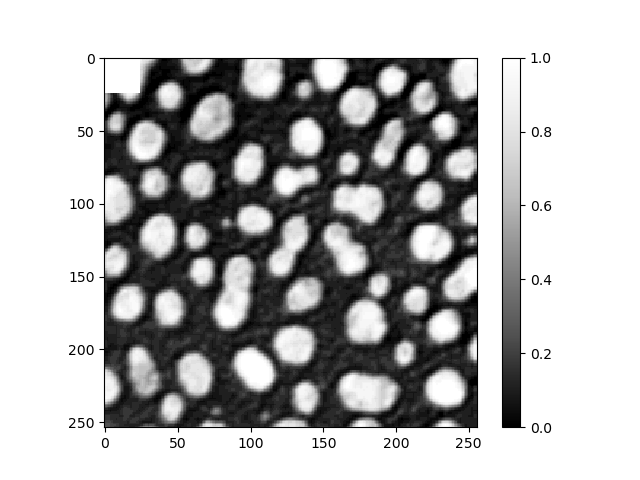
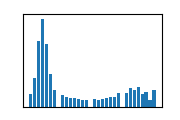

In [34]:
percentile_image_clipped = np.clip(percentile_image_unclipped, 0, 1)  
insight(percentile_image_clipped)

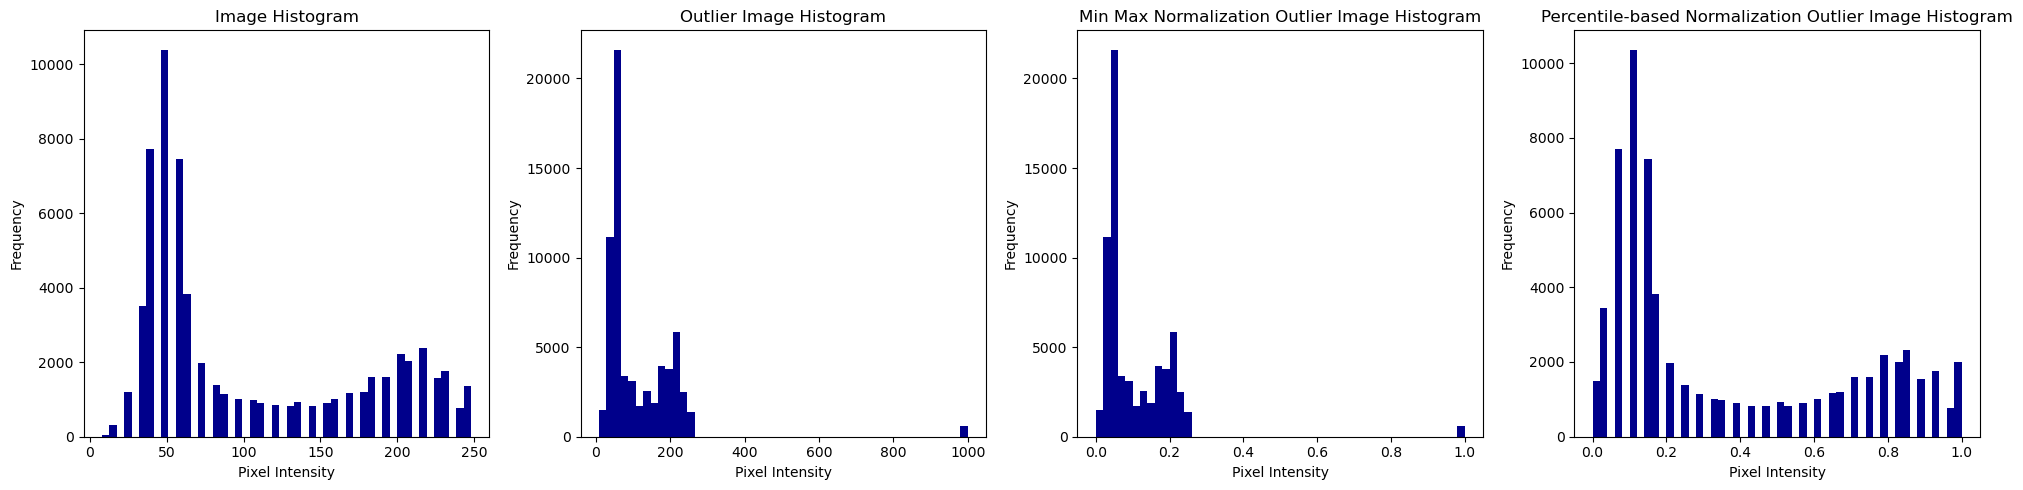

In [35]:
# Plot the histograms
fig, axes = plt.subplots(1, 4, figsize=(20, 5))  # Create two subplots side by side

# Original image histogram
axes[0].hist(image.ravel(), bins=50, color='darkblue')
axes[0].set_title('Image Histogram')
axes[0].set_xlabel('Pixel Intensity')
axes[0].set_ylabel('Frequency')

# Original image histogram
axes[1].hist(outlier_image.ravel(), bins=50, color='darkblue')
axes[1].set_title('Outlier Image Histogram')
axes[1].set_xlabel('Pixel Intensity')
axes[1].set_ylabel('Frequency')

# Original image histogram
axes[2].hist(min_max_outlier.ravel(), bins=50, color='darkblue')
axes[2].set_title('Min Max Normalization Outlier Image Histogram')
axes[2].set_xlabel('Pixel Intensity')
axes[2].set_ylabel('Frequency')

# Min-max normalized image histogram
axes[3].hist(percentile_image_clipped.ravel(), bins=50, color='darkblue')
axes[3].set_title('Percentile-based Normalization Outlier Image Histogram')
axes[3].set_xlabel('Pixel Intensity')
axes[3].set_ylabel('Frequency')

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()

# Exercise 

Another type of normalization is the [Z-score normalization](https://www.statology.org/z-score-normalization/#:~:text=Z%2Dscore%20normalization%20refers%20to,the%20standard%20deviation%20is%201.). It transforms the image such that it has a mean of 0 and standard deviation of 1 based on the following formula:

$$
Z = \frac{(X - \mu)}{\sigma}
$$

How would you implement the z-score normalization in python?



StackViewNDArray([[-0.89039758, -1.00298397, -1.11557035, ...,
                    1.58650295,  1.36133018,  1.36133018],
                  [-0.6652248 , -0.89039758, -1.11557035, ...,
                    1.81167573,  1.58650295,  1.58650295],
                  [-0.55263842, -0.77781119, -1.11557035, ...,
                    1.92426211,  1.81167573,  1.81167573],
                  ...,
                  [-0.44005203, -0.32746564, -0.32746564, ...,
                   -0.77781119, -0.77781119, -0.77781119],
                  [-0.32746564, -0.32746564, -0.32746564, ...,
                   -0.77781119, -0.77781119, -0.77781119],
                  [-0.10229286, -0.21487925, -0.32746564, ...,
                   -0.77781119, -0.77781119, -0.77781119]])
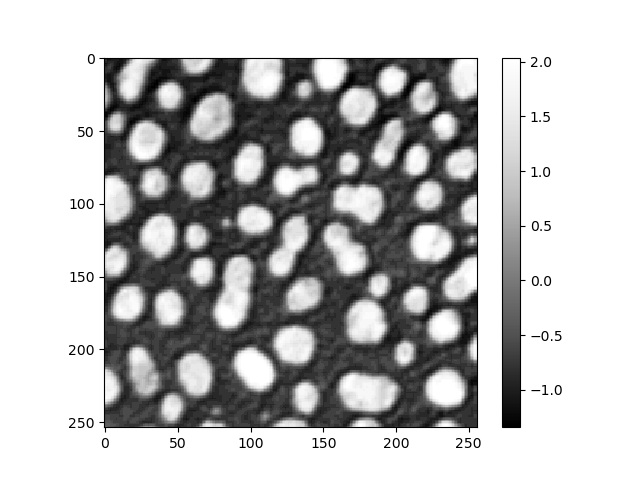
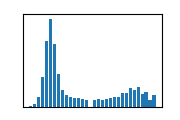

In [18]:
z_score_normalized_image = (image - np.mean(image)) / np.std(image)
insight(z_score_normalized_image)

# Overview 

We have now investigated different normalization techniques which we can summarize in the following table:

| **Normalization Technique**         | **Formula**                                      | **Description**                                           | **Advantages**                                          | **Disadvantages**                                   |
|-------------------------------------|--------------------------------------------------|----------------------------------------------------------|--------------------------------------------------------|-----------------------------------------------------|
| **Min-Max Normalization**           | $$ X' = \frac{X - X_{min}}{X_{max} - X_{min}} $$ | Rescales data to fixed range, typically [0, 1]. | Simple implementation, preserves relationships between data points. | Sensitivity to outliers can distort data distribution. |
| **Percentile-Based Normalization**  | $$ X' = \frac{X - P_{low}}{P_{high} - P_{low}} $$ | Takes into account relative rank of each intensity in the distribution (e.g.,  1st and 99th). | Reduces influence of outliers. | Requires careful selection of percentiles, may not represent all data well. |
| **Z-Score Normalization**           | $$ Z = \frac{X - \mu}{\sigma} $$               | Standardizes data by removing mean and scaling to unit variance. | Useful for normally distributed data, reduces effect of outliers. | Assumes normality, may not perform well with non-Gaussian data. |